# Модель по переносу двух стилей на фото, по сегментационой маске

In [ ]:
!pip3 install torch torchvision
!pip3 install pillow==4.1.1

     |████████████████████████████████| 11.3MB 7.0MB/s 
     |████████████████████████████████| 112kB 41.1MB/s 
  Created wheel for pillow: filename=Pillow-4.1.1-cp37-cp37m-linux_x86_64.whl size=1009476 sha256=18471fc5becfacf8e500cad3c984e7b1b994e83c344cb93fc69c1edfa7c9a803
  Stored in directory: /root/.cache/pip/wheels/3f/f3/3e/f24b51fe136968f797933559011acd48b16708fc306c924770
  Created wheel for olefile: filename=olefile-0.46-py2.py3-none-any.whl size=35416 sha256=d82e0124f71df33a74236bd6c96cf7a8f982d38a369d4d4fcb7dba2f2edf597f
  Stored in directory: /root/.cache/pip/wheels/4b/f4/11/bc4166107c27f07fd7bba707ffcb439619197638a1ac986df3
Successfully built pillow olefile
ERROR: scikit-image 0.16.2 has requirement pillow>=4.3.0, but you'll have pillow 4.1.1 which is incompatible.
ERROR: bokeh 2.3.1 has requirement pillow>=7.1.0, but you'll have pillow 4.1.1 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incom

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
%matplotlib inline
from PIL import Image
import copy

In [ ]:
!ls  /content/gdrive/MyDrive/images

 800px-The_Scream.jpg	   IMG_20180728_174826.jpg   picasso.jpg
 dancing.jpg		   IMG-20201102-WA0120.jpg  'Van Gog.jpg'
 fF_rJGFZ1y0.jpg	   lisa.jpg		     wheatfield-with-crows.jpg
 IMG_20180728_174621.jpg   mone.jpg


In [ ]:
imsize = 256
loader = transforms.Compose([
transforms.Resize(imsize),
transforms.CenterCrop(imsize),
transforms.ToTensor()
])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img_2 = image_loader("/content/gdrive/MyDrive/images/800px-The_Scream.jpg")
content_img = image_loader("/content/gdrive/MyDrive/images/IMG-20201102-WA0120.jpg")
style_img_1 = image_loader("/content/gdrive/MyDrive/images/Van Gog.jpg")

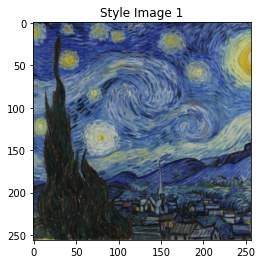

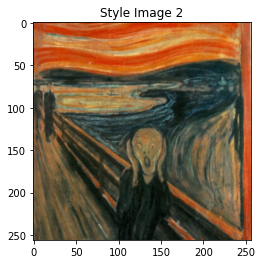

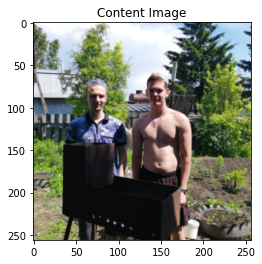

In [ ]:
unloader = transforms.ToPILImage() 

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)     
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

# отрисовка

plt.figure()
imshow(style_img_1, title='Style Image 1')
imshow(style_img_2, title='Style Image 2')
plt.figure()
imshow(content_img, title='Content Image')

In [ ]:
def gram_matrix(input):
        batch_size , h, w, f_map_num = input.size()  


        features = input.view(batch_size * h, w * f_map_num)  

        G = torch.mm(features, features.t())  #

        return G.div(batch_size * h * w * f_map_num)

Привидем картинки к необходимому виду.

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [ ]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()

            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

Загружаем преобученую vgg сеть. Она будет давать некоторые непредсказуемые участки в маску.

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [ ]:
fcn = models.segmentation.fcn_resnet50(pretrained=True)
#дообучить модель на СОСО и сделать нормальные сегментационые маски

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
set_parameter_requires_grad(fcn,1)

In [ ]:
fcn.to(device)
fcn.eval()  
#Y_hat = fcn(output.to(device))

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [ ]:
Определяем функции потерь для текстуры и для деталей картинки. 

In [ ]:
class ContentLoss(nn.Module):
        def __init__(self, target,):
            super(ContentLoss, self).__init__()

            self.target = target.detach()
            self.loss = F.mse_loss(self.target, self.target )

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

In [ ]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature_1, target_feature_2,style_weight_1,style_weight_2,Y_fon,Y_not_fon):
            super(StyleLoss, self).__init__()
            #print(target_feature_2*Y_not_fon)
            self.target_1 = gram_matrix(target_feature_1).detach()
            self.target_2 = gram_matrix(target_feature_2).detach()
            self.st_1 = style_weight_1 
            self.st_2 = style_weight_2
            self.Y_fon = Y_fon
            self.Y_not_fon = Y_not_fon
            self.content_img = content_img

            self.loss = F.mse_loss(self.target_1, self.target_1)*self.st_1 + F.mse_loss(self.target_2, self.target_2)*self.st_2

        def forward(self, input):
            G_1 = gram_matrix(input*self.Y_fon)
            G_2 = gram_matrix(input*self.Y_not_fon)
            self.loss = F.mse_loss(G_1, self.target_1)*self.st_1 +  F.mse_loss(G_2, self.target_2)*self.st_2
            return input

Создаем маску по которой будет проходить граница стилей.

In [ ]:
def mask_norm(input):
  mean = torch.mean(input)
  std = torch.std(input)
  return (input -mean)/std
                  

In [ ]:
def mask(content_img,size_1, size_2):
      Y_not_fon =(mask_norm(fcn(content_img.to(device))['out'][0,0].detach().to('cpu'))<0.5).to(torch.float32)
      Y_fon =(mask_norm(fcn(content_img.to(device))['out'][0,0].detach().to('cpu'))>0.5).to(torch.float32)
      Y_fon = Y_fon.view([1, 1, 256, 256])
      Y_not_fon = Y_not_fon.view([1, 1, 256, 256])
      k_1 =Y_fon
      k_2 = Y_not_fon
      while Y_fon.size()[1]!=size_1:
        Y_fon = torch.cat([Y_fon,k_1],1)
        Y_not_fon = torch.cat([Y_not_fon,k_2],1)

      while Y_fon.size()[2]!=size_2:
        m = nn.AvgPool2d(2)
        Y_fon = (m(Y_fon)>0.5).to(torch.float32)
        Y_not_fon =(m(Y_not_fon)>0.5).to(torch.float32)

      return Y_fon ,Y_not_fon

In [ ]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_img_1, style_img_2,  content_img, style_weight_1,style_weight_2,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        content_losses = []
        style_losses = []

        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
 
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)
            fcn.eval()  

            if name in content_layers:

                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:

                target_feature_1 = model(style_img_1).detach()
                target_feature_2 = model(style_img_2).detach()
                Y_fon,Y_not_fon =mask(content_img, target_feature_1.size()[1],target_feature_1.size()[2])
                style_loss = StyleLoss(target_feature_1, target_feature_2, style_weight_1,style_weight_2, Y_fon ,Y_not_fon)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_img_1,style_img_2, input_img, num_steps=500,
                        style_weight_1=100000,style_weight_2=500000, content_weight=0.5):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_img_1,style_img_2, content_img, style_weight_1,style_weight_2)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():

                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                

                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

                return style_score + content_score
            imshow(input_img, title='input_img')
            optimizer.step(closure)
            
        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img




In [ ]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [ ]:
def get_input_optimizer(input_img):

        optimizer = optim.LBFGS([input_img.requires_grad_()],lr=0.05) 
        return optimizer

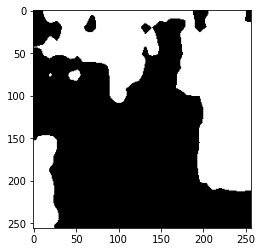

In [ ]:
 Y_not_fon =(mask_norm(fcn(content_img.to(device))['out'][0,0].detach().to('cpu'))>0.5).to(torch.float32)
plt.imshow(Y_not_fon ,'gray')

Обучаем модель и наблюдаем за результатом.

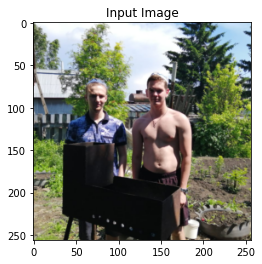

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..


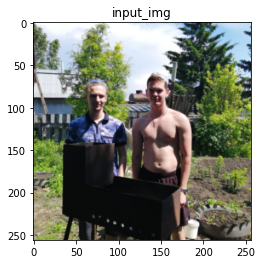

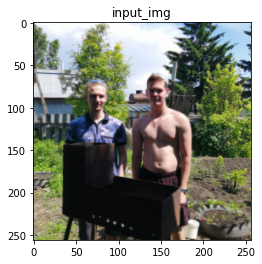

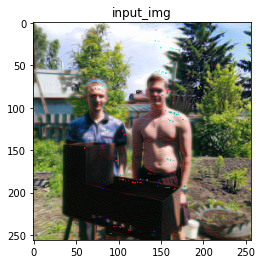

run [50]:
Style Loss : 179.030106 Content Loss: 12.706844



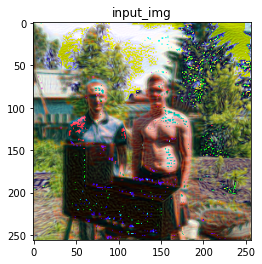

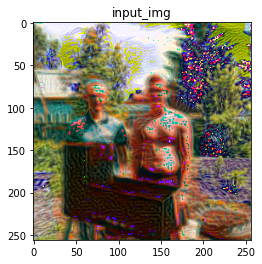

run [100]:
Style Loss : 35.732819 Content Loss: 22.759069



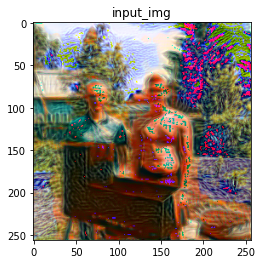

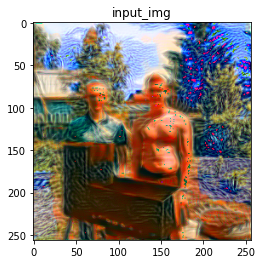

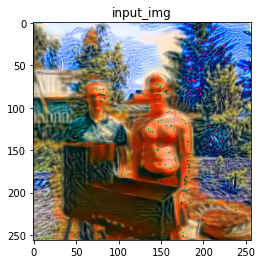

run [150]:
Style Loss : 21.655050 Content Loss: 17.218197



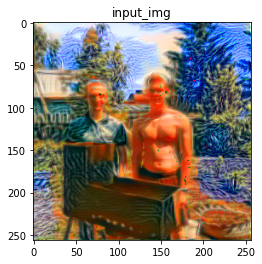

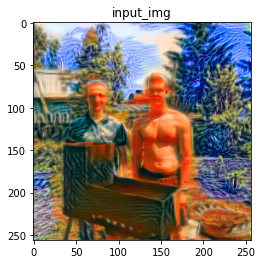

run [200]:
Style Loss : 17.227964 Content Loss: 15.109871



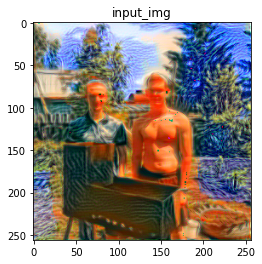

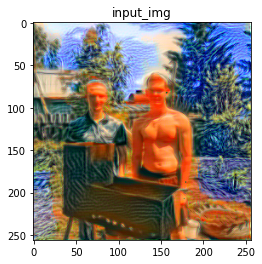

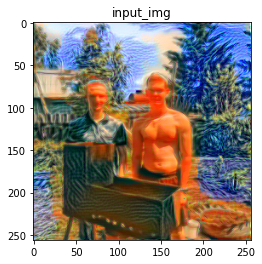

run [250]:
Style Loss : 15.203251 Content Loss: 14.147949



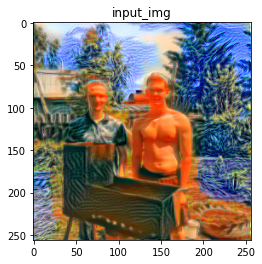

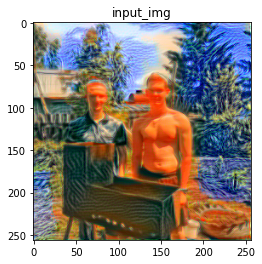

run [300]:
Style Loss : 14.134314 Content Loss: 13.466385



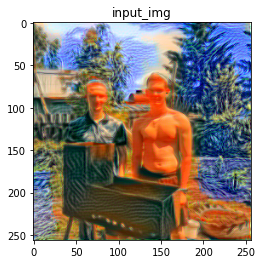

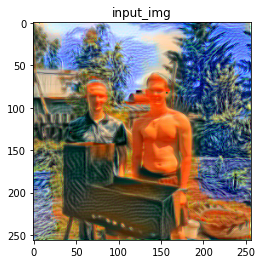

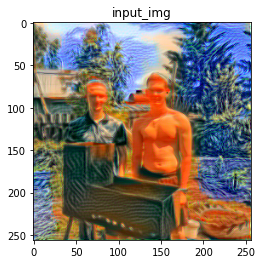

run [350]:
Style Loss : 13.392735 Content Loss: 13.085876



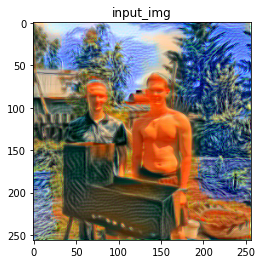

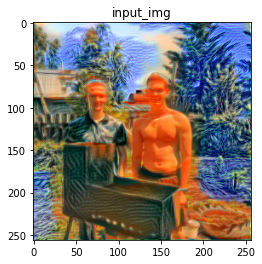

run [400]:
Style Loss : 12.818359 Content Loss: 12.736810



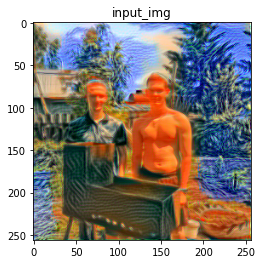

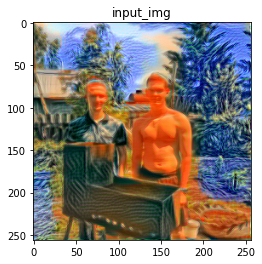

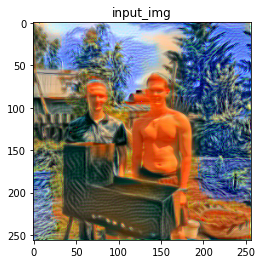

run [450]:
Style Loss : 12.417083 Content Loss: 12.500076



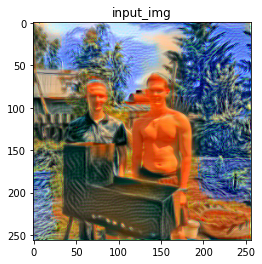

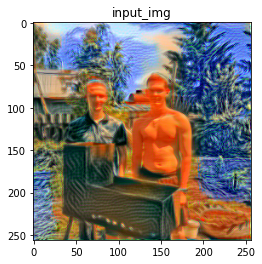

run [500]:
Style Loss : 12.072728 Content Loss: 12.286743



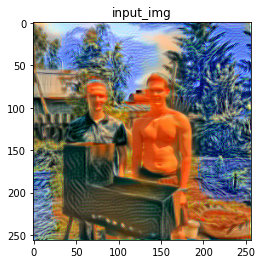

In [ ]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, 
                            content_img, style_img_1,style_img_2, input_img,
                       content_weight=1)